In [1]:
import sys
import numpy as np
import pysindy as ps
import inspect
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import copy

from pysindy.feature_library import GeneralizedLibrary, PolynomialLibrary, FourierLibrary, CustomLibrary, ConcatLibrary


In [2]:
def SaturatedGrowthModel(t, u, C):
        return u*(C-u)
def plot_pareto(coefs, opt, model, threshold_scan, x_test, t_test):
    dt = t_test[1] - t_test[0]
    mse = np.zeros(len(threshold_scan))
    mse_sim = np.zeros(len(threshold_scan))
    for i in range(len(threshold_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0,:], t_test, integrator="odeint")
        if np.any(x_test_sim > 1e4):
            x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test - x_test_sim) ** 2)
    
    #plt.figure(figsize=(5, 2), dpi=300)
    plt.figure()
    plt.semilogy(threshold_scan, mse, "bo")
    plt.semilogy(threshold_scan, mse, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=16)
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    
    # plt.figure(figsize=(5, 2), dpi=300)
    # plt.figure()
    plt.semilogy(threshold_scan, mse_sim, "bo")
    plt.semilogy(threshold_scan, mse_sim, "b")
    plt.ylabel(r"$\dot{X}$ RMSE SIM", fontsize=16)
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)

# Model Comparison
def plot_models(t_end, initial_condition, params, original_model, sindy_model):
    t_span = (0, t_end)
    t_eval = np.linspace(t_span[0], t_span[1], 500)
    sol = solve_ivp(original_model, t_span, initial_condition, args=(params,), t_eval=t_eval)
    t = sol.t
    u_sol = sol.y.T.reshape(-1)

    # syndy model output
    out = sindy_model.simulate(initial_condition, t_eval, integrator='odeint')
    u_predicted = out[:, 0]
    # v_predicted = out[:, 1]

    # plot
    plt.figure(figsize=(5, 3))
    plt.plot(t, u_sol, label='Original u', color='blue')
    plt.plot(t, u_predicted, label='SINDy u', linestyle='--', color='yellow')
    # plt.plot(t, v_sol, label='Original v', color='red')
    # plt.plot(t, v_predicted, label='SINDy v', linestyle='--', color='black')
    plt.xlabel('Time (t)')
    plt.ylabel('Population')
    plt.title('Comparison of Original and SINDy Models')
    plt.legend()
    plt.show()

In [3]:
initial_conditions = [0.01]
C = 1.0
t_end = 24
t_span = (0, t_end)
t_eval = np.linspace(t_span[0], t_span[1], 5000)

# Training Datasets
sol = solve_ivp(SaturatedGrowthModel, t_span, initial_conditions, args=(C,), t_eval=t_eval)
t_train = sol.t
x_train = sol.y.T.reshape(-1)
print(t_train.shape, x_train.shape)

(5000,) (5000,)


In [23]:
# Test datasets
sol_test = solve_ivp(SaturatedGrowthModel, t_span, initial_conditions, args=(C,), t_eval=t_eval)
t_test = sol_test.t
x_test = sol_test.y.T
print(x_test.shape, t_test.shape)

#plt.plot(t_train, x_train)

(5000, 1) (5000,)


(u)' = 1.001 u + -1.001 u^2


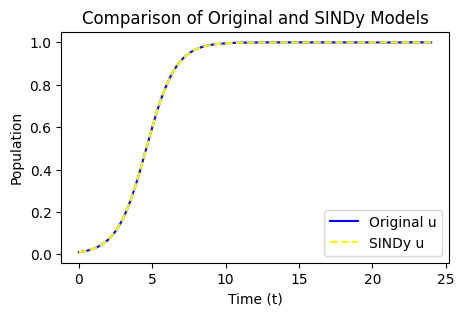

In [25]:
# try PySINDy 
model = ps.SINDy(feature_names=["u"], optimizer=ps.SR3(threshold=0.05))
model.fit(x_train, t=t_train)
model.print()
plot_models(t_end, initial_conditions, C, SaturatedGrowthModel, model)

Add noise

(u)' = 0.996 u + -0.996 u^2


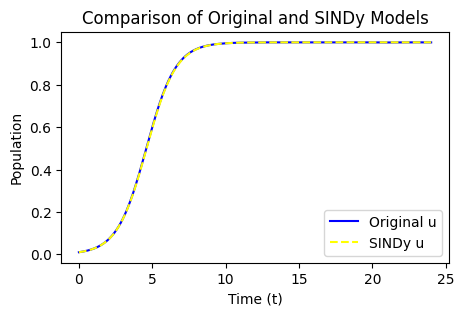

In [26]:
np.random.seed(0)
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse/100.0, x_train.shape)
feature_names = ["u"]

poly_order = 2
poly_library = PolynomialLibrary(degree=poly_order)
fourier_library = FourierLibrary()
combined_library = GeneralizedLibrary([poly_library, fourier_library])

sparse_regression_optimizer = ps.SR3(threshold=0.3, thresholder="l1")
modelX = ps.SINDy(feature_names=feature_names,
                     optimizer=sparse_regression_optimizer, 
                     feature_library=poly_library,)

modelX.fit(x_train_added_noise, t=t_train, quiet=True)
modelX.print()
plot_models(t_end, initial_conditions, C, SaturatedGrowthModel, modelX)

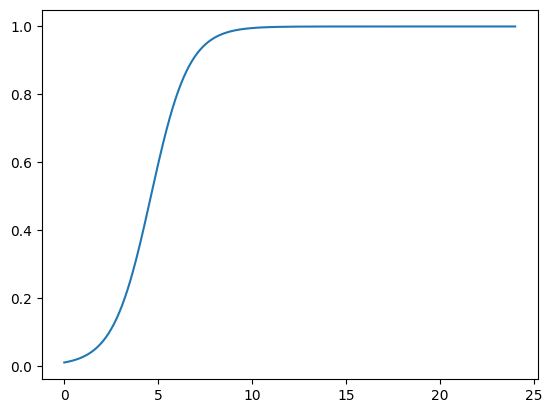

In [29]:
out = modelX.simulate(initial_conditions, t_eval, integrator='odeint')
out[:, 0] = np.where(out[:, 0] > 2 , 0, out[:, 0])
plt.plot(t_train, out[:, 0])

0.01
(u)' = 1.001 u + -1.001 u^2
0.01473684210526316
(u)' = 1.001 u + -1.001 u^2
0.019473684210526317
(u)' = 1.001 u + -1.001 u^2
0.024210526315789474
(u)' = 1.001 u + -1.001 u^2


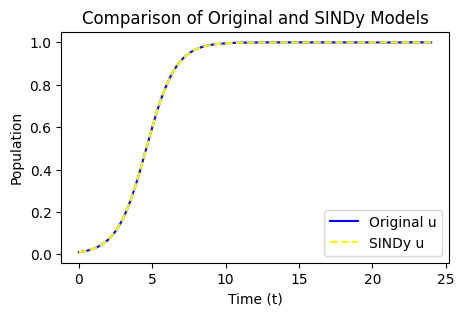

0.02894736842105263
(u)' = 1.001 u + -1.001 u^2
0.03368421052631579
(u)' = 1.001 u + -1.001 u^2
0.03842105263157895
(u)' = 1.001 u + -1.001 u^2
0.04315789473684211
(u)' = 1.001 u + -1.001 u^2
0.04789473684210527
(u)' = 1.001 u + -1.001 u^2
0.052631578947368425
(u)' = 1.001 u + -1.001 u^2
0.05736842105263158
(u)' = 1.001 u + -1.001 u^2
0.06210526315789474
(u)' = 1.001 u + -1.001 u^2
0.0668421052631579
(u)' = 1.001 u + -1.001 u^2
0.07157894736842106
(u)' = 1.001 u + -1.001 u^2
0.07631578947368421
(u)' = 1.001 u + -1.001 u^2
0.08105263157894736
(u)' = 1.001 u + -1.001 u^2
0.08578947368421053
(u)' = 1.001 u + -1.001 u^2
0.09052631578947369
(u)' = 1.001 u + -1.001 u^2
0.09526315789473684
(u)' = 1.001 u + -1.001 u^2
0.1
(u)' = 1.001 u + -1.001 u^2


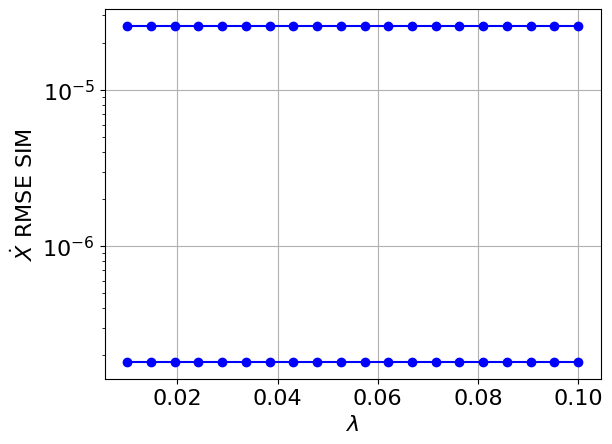

In [5]:
threshold_scan = np.linspace(0.01, 0.1, 20)
coefs = []
np.random.seed(0)
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 100.0,  x_train.shape)
feature_names = ["u"]

poly_order = 2
poly_library = PolynomialLibrary(degree=poly_order)
fourier_library = FourierLibrary()
combined_library = GeneralizedLibrary([poly_library, fourier_library])

for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.SR3(threshold=threshold, thresholder="l1")
    modelX = ps.SINDy(feature_names=feature_names,
                     optimizer=sparse_regression_optimizer, 
                     feature_library=poly_library,)
    # modelX.fit(x_train_added_noise, t=t_train, quiet=True)
    modelX.fit(x_train, t=t_train, quiet=True)
    coefs.append(modelX.coefficients())
    print(threshold)
    modelX.print()
    if i == 3:
        plot_models(t_end, initial_conditions, C, SaturatedGrowthModel, modelX)

plot_pareto(coefs, sparse_regression_optimizer, modelX,
            threshold_scan, x_test, t_test)

Add time window

0.0 0
(u)' = -0.015 1 + 1.082 u + -1.077 u^2
0.0033444816053511705 1
(u)' = -0.015 1 + 1.082 u + -1.077 u^2
0.006688963210702341 2
(u)' = -0.015 1 + 1.082 u + -1.077 u^2
0.010033444816053512 3
(u)' = -0.015 1 + 1.082 u + -1.077 u^2
0.013377926421404682 4
(u)' = 1.016 u + -1.023 u^2
0.016722408026755852 5
(u)' = 1.016 u + -1.023 u^2


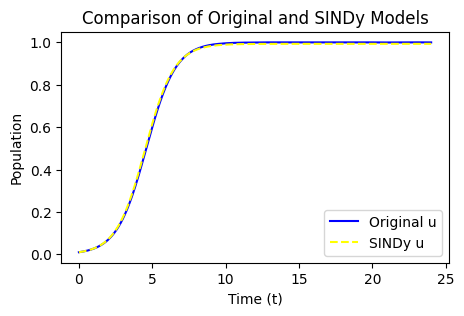

0.020066889632107024 6
(u)' = 1.016 u + -1.023 u^2
0.023411371237458192 7
(u)' = 1.016 u + -1.023 u^2
0.026755852842809364 8
(u)' = 1.016 u + -1.023 u^2
0.030100334448160536 9
(u)' = 1.016 u + -1.023 u^2
0.033444816053511704 10
(u)' = 1.016 u + -1.023 u^2
0.03678929765886287 11
(u)' = 1.016 u + -1.023 u^2
0.04013377926421405 12
(u)' = 1.016 u + -1.023 u^2
0.043478260869565216 13
(u)' = 1.016 u + -1.023 u^2
0.046822742474916385 14
(u)' = 1.016 u + -1.023 u^2
0.05016722408026756 15
(u)' = 1.016 u + -1.023 u^2
0.05351170568561873 16
(u)' = 1.016 u + -1.023 u^2
0.056856187290969896 17
(u)' = 1.016 u + -1.023 u^2
0.06020066889632107 18
(u)' = 1.016 u + -1.023 u^2
0.06354515050167224 19
(u)' = 1.016 u + -1.023 u^2
0.06688963210702341 20
(u)' = 1.016 u + -1.023 u^2
0.07023411371237458 21
(u)' = 1.016 u + -1.023 u^2
0.07357859531772575 22
(u)' = 1.016 u + -1.023 u^2
0.07692307692307693 23
(u)' = 1.016 u + -1.023 u^2
0.0802675585284281 24
(u)' = 1.016 u + -1.023 u^2
0.08361204013377926 25
(u)' 

c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\Users\tirth\anaconda3\envs\pysindy\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quanti

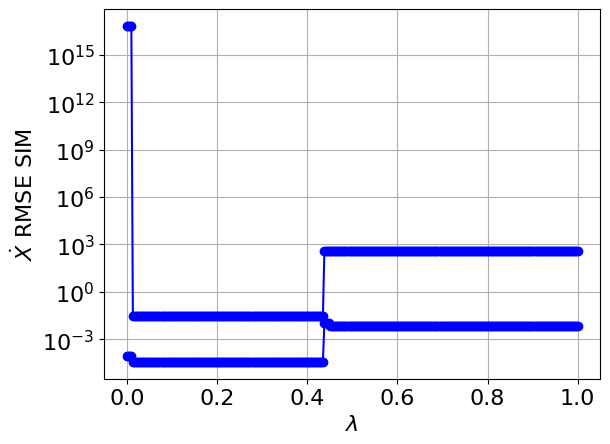

In [7]:
threshold_scan = np.linspace(0, 1, 300)
coefs = []
time_window = [0, 10]
mask = (t_train == 0) | ((t_train >= time_window[0]) & (t_train <= time_window[1]))
np.random.seed(0)

t_filtered = t_train[mask]
x_filtered = x_train[mask]

x_train_added_noise = x_filtered + np.random.normal(0, rmse / 100.0,  x_filtered.shape)
feature_names = ["u"]

poly_order = 2
poly_library = PolynomialLibrary(degree=poly_order)
fourier_library = FourierLibrary()
combined_library = GeneralizedLibrary([poly_library, fourier_library])

for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.SR3(threshold=threshold, thresholder="l1")
    modelX = ps.SINDy(feature_names=feature_names,
                     optimizer=sparse_regression_optimizer, 
                     feature_library=poly_library,)
    modelX.fit(x_train_added_noise, t=t_filtered, quiet=True)
    coefs.append(modelX.coefficients())
    print(threshold, i)
    modelX.print()
    if i == 5:
        plot_models(t_end, initial_conditions, C, SaturatedGrowthModel, modelX)

plot_pareto(coefs, sparse_regression_optimizer, modelX,
            threshold_scan, x_test, t_test)

(-0.5, 25.0)

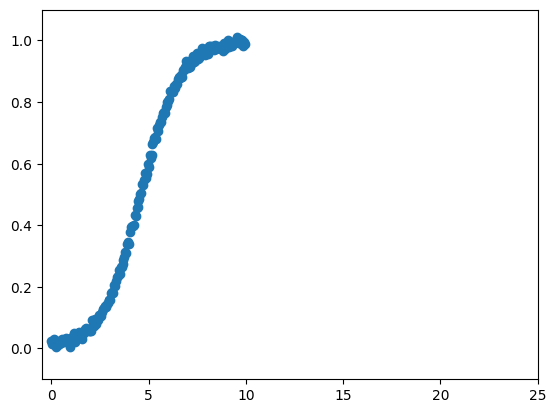

In [57]:
plt.scatter(t_filtered, x_train_added_noise)
plt.ylim(-.1,1.1)
plt.xlim(-.5, 25)

with custom library


Function output shape: (500,)
Function output shape: (500,)
0.0
(u)' = 1.016 u + -1.023 u^2
0.00010033444816053511
(u)' = 1.016 u + -1.023 u^2
0.00020066889632107022
(u)' = 1.016 u + -1.023 u^2
0.00030100334448160534
(u)' = 1.016 u + -1.023 u^2
0.00040133779264214044
(u)' = 1.016 u + -1.023 u^2
0.0005016722408026755
(u)' = 1.016 u + -1.023 u^2
0.0006020066889632107
(u)' = 1.016 u + -1.023 u^2
0.0007023411371237457
(u)' = 1.016 u + -1.023 u^2
0.0008026755852842809
(u)' = 1.016 u + -1.023 u^2
0.000903010033444816
(u)' = 1.016 u + -1.023 u^2
0.001003344481605351
(u)' = 1.016 u + -1.023 u^2
0.001103678929765886
(u)' = 1.016 u + -1.023 u^2
0.0012040133779264214
(u)' = 1.016 u + -1.023 u^2
0.0013043478260869564
(u)' = 1.016 u + -1.023 u^2
0.0014046822742474914
(u)' = 1.016 u + -1.023 u^2
0.0015050167224080267
(u)' = 1.016 u + -1.023 u^2
0.0016053511705685617
(u)' = 1.016 u + -1.023 u^2
0.0017056856187290968
(u)' = 1.016 u + -1.023 u^2
0.001806020066889632
(u)' = 1.016 u + -1.023 u^2
0.001906

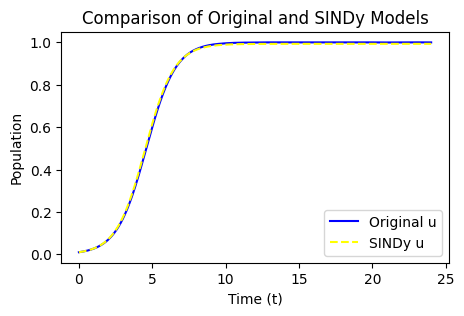

0.005819397993311036
(u)' = 1.016 u + -1.023 u^2
0.005919732441471572
(u)' = 1.016 u + -1.023 u^2
0.006020066889632107
(u)' = 1.016 u + -1.023 u^2
0.006120401337792642
(u)' = 1.016 u + -1.023 u^2
0.0062207357859531765
(u)' = 1.016 u + -1.023 u^2
0.006321070234113712
(u)' = 1.016 u + -1.023 u^2
0.006421404682274247
(u)' = 1.016 u + -1.023 u^2
0.006521739130434782
(u)' = 1.016 u + -1.023 u^2
0.0066220735785953175
(u)' = 1.016 u + -1.023 u^2
0.006722408026755852
(u)' = 1.016 u + -1.023 u^2
0.006822742474916387
(u)' = 1.016 u + -1.023 u^2
0.006923076923076922
(u)' = 1.016 u + -1.023 u^2
0.007023411371237458
(u)' = 1.016 u + -1.023 u^2
0.007123745819397993
(u)' = 1.016 u + -1.023 u^2
0.007224080267558528
(u)' = 1.016 u + -1.023 u^2
0.007324414715719063
(u)' = 1.016 u + -1.023 u^2
0.007424749163879598
(u)' = 1.016 u + -1.023 u^2
0.007525083612040133
(u)' = 1.016 u + -1.023 u^2
0.007625418060200668
(u)' = 1.016 u + -1.023 u^2
0.007725752508361204
(u)' = 1.016 u + -1.023 u^2
0.0078260869565217

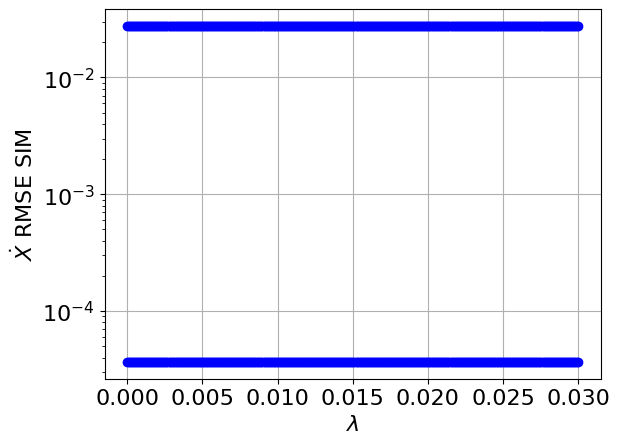

In [15]:
threshold_scan = np.linspace(0, 0.03, 300)
coefs = []
time_window = [0, 10]
mask = (t_train == 0) | ((t_train >= time_window[0]) & (t_train <= time_window[1]))
np.random.seed(0)

t_filtered = t_train[mask]
x_filtered = x_train[mask]

x_train_added_noise = x_filtered + np.random.normal(0, rmse / 100.0,  x_filtered.shape)
feature_names = ["u"]

custom_functions = [lambda u:u, 
                    lambda u:u**2]
function_names = [
                lambda u : f"{u}",
                lambda u : f"{u}^2"
                ]

custom_library = CustomLibrary(library_functions=custom_functions, function_names=function_names, include_bias=False).fit(x_train)

for f in custom_functions:
    print("Function output shape:", f(x_train).shape)


for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.SR3(threshold=threshold, thresholder="l1")
    modelX = ps.SINDy(feature_names=feature_names,
                     optimizer=sparse_regression_optimizer, 
                     feature_library=custom_library,)
    modelX.fit(x_train_added_noise, t=t_filtered, quiet=True)
    coefs.append(modelX.coefficients())
    print(threshold, i)
    modelX.print()
    if i == 57:
        plot_models(t_end, initial_conditions, C, SaturatedGrowthModel, modelX)

plot_pareto(coefs, sparse_regression_optimizer, modelX,
            threshold_scan, x_test, t_test)

Function output shape: (5000,)
Function output shape: (5000,)
0.0 0
(u)' = 1.006 u + -1.011 u^2
0.0033444816053511705 1
(u)' = 1.006 u + -1.011 u^2
0.006688963210702341 2
(u)' = 1.006 u + -1.011 u^2
0.010033444816053512 3
(u)' = 1.006 u + -1.011 u^2
0.013377926421404682 4
(u)' = 1.006 u + -1.011 u^2
0.016722408026755852 5
(u)' = 1.006 u + -1.011 u^2
0.020066889632107024 6
(u)' = 1.006 u + -1.011 u^2
0.023411371237458192 7
(u)' = 1.006 u + -1.011 u^2
0.026755852842809364 8
(u)' = 1.006 u + -1.011 u^2


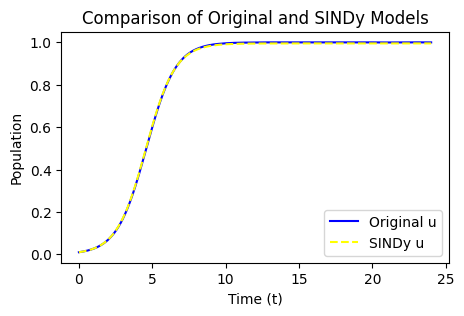

0.030100334448160536 9
(u)' = 1.006 u + -1.011 u^2
0.033444816053511704 10
(u)' = 1.006 u + -1.011 u^2
0.03678929765886287 11
(u)' = 1.006 u + -1.011 u^2
0.04013377926421405 12
(u)' = 1.006 u + -1.011 u^2
0.043478260869565216 13
(u)' = 1.006 u + -1.011 u^2
0.046822742474916385 14
(u)' = 1.006 u + -1.011 u^2
0.05016722408026756 15
(u)' = 1.006 u + -1.011 u^2
0.05351170568561873 16
(u)' = 1.006 u + -1.011 u^2
0.056856187290969896 17
(u)' = 1.006 u + -1.011 u^2
0.06020066889632107 18
(u)' = 1.006 u + -1.011 u^2
0.06354515050167224 19
(u)' = 1.006 u + -1.011 u^2
0.06688963210702341 20
(u)' = 1.006 u + -1.011 u^2
0.07023411371237458 21
(u)' = 1.006 u + -1.011 u^2
0.07357859531772575 22
(u)' = 1.006 u + -1.011 u^2
0.07692307692307693 23
(u)' = 1.006 u + -1.011 u^2
0.0802675585284281 24
(u)' = 1.006 u + -1.011 u^2
0.08361204013377926 25
(u)' = 1.006 u + -1.011 u^2
0.08695652173913043 26
(u)' = 1.006 u + -1.011 u^2
0.0903010033444816 27
(u)' = 1.006 u + -1.011 u^2
0.09364548494983277 28
(u)' =

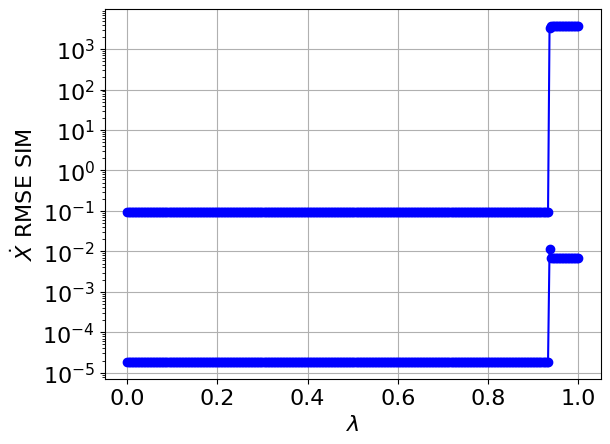

In [29]:
threshold_scan = np.linspace(0, 1, 300)
coefs = []
time_window = [0, 10]
mask = (t_train == 0) | ((t_train >= time_window[0]) & (t_train <= time_window[1]))
np.random.seed(0)

t_filtered = t_train[mask]
x_filtered = x_train[mask]

x_train_added_noise = x_filtered + np.random.normal(0, rmse / 100.0,  x_filtered.shape)
feature_names = ["u"]

custom_functions = [lambda u:u, 
                    lambda u:u**2]
function_names = [
                lambda u : f"{u}",
                lambda u : f"{u}^2"
                ]

custom_library = CustomLibrary(library_functions=custom_functions, function_names=function_names, include_bias=False).fit(x_train_added_noise)

for f in custom_functions:
    print("Function output shape:", f(x_train).shape)


for i, threshold in enumerate(threshold_scan):
    sparse_regression_optimizer = ps.SR3(threshold=threshold, thresholder="l1")
    modelX = ps.SINDy(feature_names=feature_names,
                     optimizer=sparse_regression_optimizer, 
                     feature_library=custom_library,)
    modelX.fit(x_train_added_noise, t=t_filtered, quiet=True)
    coefs.append(modelX.coefficients())
    print(threshold, i)
    modelX.print()
    if i == 8:
        plot_models(t_end, initial_conditions, C, SaturatedGrowthModel, modelX)

plot_pareto(coefs, sparse_regression_optimizer, modelX,
            threshold_scan, x_test, t_test)

In [4]:
import os

def CompetitionModel(t, q, params):
        u, v = q
        # r, a1, a2, b1,b2
        r, a1, a2, b1,b2 = params
        dudt = u*(1-a1*u- a2*v)  
        dvdt = r*v*(1-b1*u-b2*v)
        return [dudt, dvdt]

# Create training and test datasets
def create_datasets(model, tend, numx, nTest, initial_conditions, params, training_time_limit, noise_level, show_figure=False, save_path=None, sparse=False):
    t_span = (0, tend)
    np.random.seed(0)
    if sparse:
         t_eval = np.sort(np.random.uniform(0, tend, numx))
         t_eval[0]  = 0.0
    else:
         t_eval = np.linspace(t_span[0], t_span[1], numx)

    # training datasets
    sol = solve_ivp(model, t_span, initial_conditions, args=(params,), t_eval=t_eval)
    t_train = sol.t
    x_train = sol.y.T

    mask = (t_train == 0) | ((t_train >= training_time_limit[0]) & (t_train <= training_time_limit[1]))
    t_filtered = t_train[mask]
    x_filtered = x_train[mask]

    noise = np.random.normal(0, noise_level, x_filtered.shape)
    x_filtered_noisy = x_filtered + noise
    u_train = x_filtered_noisy[:, 0]
    if model==CompetitionModel:
        v_train = x_filtered_noisy[:, 1]

    # Test datasets
    t_eval = np.linspace(0, tend, nTest)
    sol_test = solve_ivp(model, t_span, initial_conditions, args=(params,), t_eval=t_eval)
    t_test = sol_test.t
    x_test = sol_test.y.T

    if show_figure:
        plt.figure(figsize=(5, 3))
        plt.scatter(t_filtered, u_train, label='u(t)')
        if model==CompetitionModel:
            plt.scatter(t_filtered, v_train, label='v(t)')
        plt.xlabel('Time (t)')
        plt.ylabel('u')
        plt.title('Competition Model Data')
        plt.legend()
        if save_path:
            if os.path.basename(save_path) == '':
                raise ValueError("Please provide a file name with the save path.")
            plt.savefig(save_path)
        else:
            plt.show()

    return x_filtered_noisy, t_filtered, x_test, t_test

In [10]:
# Create training and test datasets
def create_datasets2(model, tend, numx, nTest, initial_conditions, params, training_time_limit, noise_level, show_figure=False, save_path=None, sparse=False):
    t_span = (0, tend)
    #np.random.seed(0)
    if sparse:
         t_eval = np.sort(np.random.uniform(training_time_limit[0], training_time_limit[1], numx))
         t_eval[0]  = 0.0
    else:
         t_eval = np.linspace(training_time_limit[0], training_time_limit[1], numx)
         t_eval[0]  = 0.0

    # training datasets
    sol = solve_ivp(model, t_span, initial_conditions, args=(params,), t_eval=t_eval)
    t_train = sol.t
    x_train = sol.y.T

    noise = np.random.normal(0, noise_level, x_train.shape)
    x_train_noisy = x_train + noise
    u_train = x_train_noisy[:, 0]
    if model==CompetitionModel:
        v_train = x_train_noisy[:, 1]

    # Test datasets
    t_eval = np.linspace(0, tend, nTest )
    sol_test = solve_ivp(model, t_span, initial_conditions, args=(params,), t_eval=t_eval)
    t_test = sol_test.t
    x_test = sol_test.y.T

    if show_figure:
        plt.figure(figsize=(5, 3))
        plt.scatter(t_train, u_train, label='u(t)')
        if model==CompetitionModel:
            plt.scatter(t_train, v_train, label='v(t)')
        plt.xlabel('Time (t)')
        plt.ylabel('u')
        plt.title('Competition Model Data')
        plt.legend()
        if save_path:
            if os.path.basename(save_path) == '':
                raise ValueError("Please provide a file name with the save path.")
            plt.savefig(save_path)
        else:
            plt.show()

    return x_train_noisy, t_train, x_test, t_test

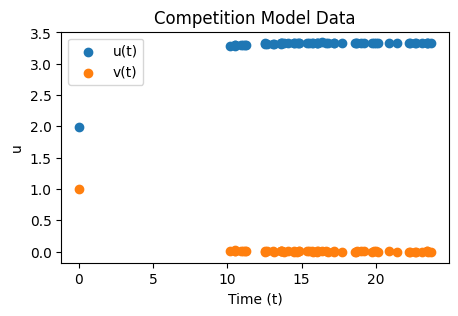

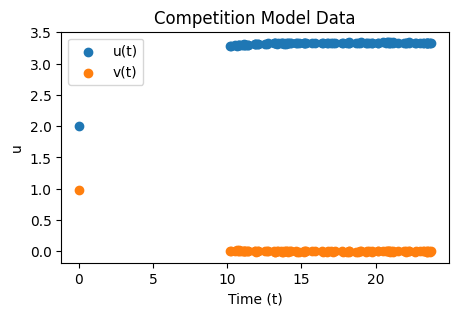

In [11]:
model = SaturatedGrowthModel
params = [0.5, 0.3, 0.6, 0.7, 0.3]
x1, t1, m1, n1 = create_datasets(CompetitionModel, 24, 100, 200, [2,1], params, [10,24], 0.005, True, None, True)
x2, t2, m2, n2 = create_datasets2(CompetitionModel, 24, 100, 200, [2,1], params, [10,24], 0.005, True, None, True)

In [12]:
x1.shape, x2.shape, t1.shape, t2.shape

((58, 2), (100, 2), (58,), (100,))

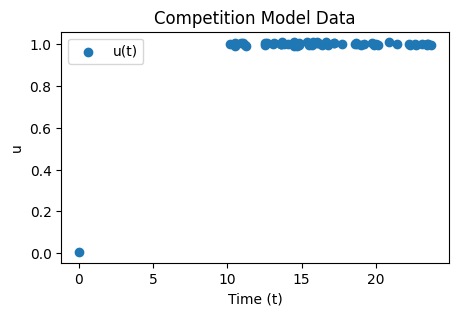

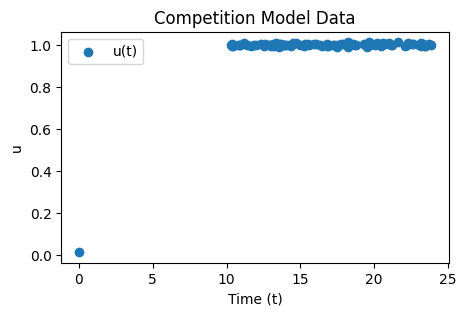

In [13]:
model = SaturatedGrowthModel
C =1 
x1, t1, m1, n1 = create_datasets(model, 24, 100, 200, [0.01], C, [10,24], 0.005, True, None, True)
x2, t2, m2, n2 = create_datasets2(model, 24, 100, 200, [0.01], C, [10,24], 0.005, True, None, True)

In [14]:
x1.shape, x2.shape, t1.shape, t2.shape

((58, 1), (100, 1), (58,), (100,))